## Loading the required libraries

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Exploration

We find after the split of data into 2 class(tumour and non-tumour), there is a big imbalance in the data. 

[(24450, 'T'), (881, 'NT')]


<BarContainer object of 2 artists>

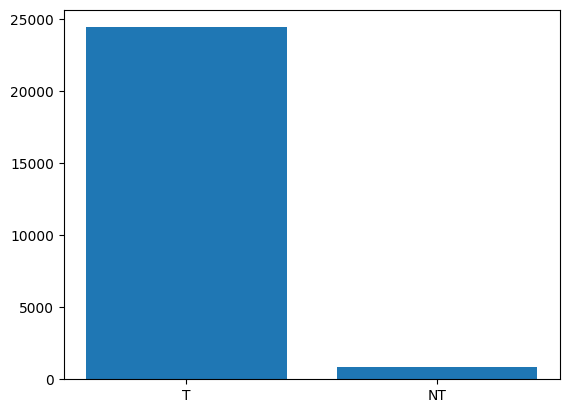

In [12]:
PATH_TO_DIR = '/home/mila/s/subhrajyoti.dasgupta/skin_lesion/binary_data/'

freq = [(len(os.listdir(PATH_TO_DIR + dir)), dir) \
        for dir in os.listdir(PATH_TO_DIR) \
        if '.' not in dir]
print(freq)
plt.bar([f[1] for f in freq], [f[0] for f in freq])

## Defining transformations and setting the DataLoaders

[NOTE] - As in a standard practice, for normalization, we have used the mean and std deviation of the Imagenet dataset.

In [13]:
# transform the image size to 255 by 255 and then center crop
transform = transforms.Compose([
      transforms.Resize(255),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406],
                           [0.229, 0.224, 0.225])])

# load train/valid/test set using ImageFolder 
dataset = datasets.ImageFolder(root=PATH_TO_DIR, transform=transform)

# Split the dataset into train, validation, and test sets
total_size = len(dataset)
train_size = int(0.95 * total_size)  # 95% for training
test_size = total_size - train_size  # rest for testing

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders for train, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=1)

In [17]:
dataset.classes

['NT', 'T']

## Loading the pre-trained model

- We are using the pre-trained VGG-16 model here mainly because of the comparatively lesser complexity it has. It is very widely used as a feature extractor and using a more complex model in such an imbalance setting may lead to overfitting.

In [48]:
# Load pretrained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Freeze convolutional layers to keep the pretrained weights
for param in vgg16.features.parameters():
    param.requires_grad = False

# Modify the classifier to match the number of classes in your dataset
num_classes = len(dataset.classes)
vgg16.classifier[-1] = nn.Linear(vgg16.classifier[-1].in_features, num_classes)

# Define loss criterion and optimizer
criterion = nn.CrossEntropyLoss()
# specify optimizer (stochastic gradient descent) and learning rate
optimizer = optim.Adam(vgg16.parameters(), lr=1e-5)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.


### Finetuning the model

In [49]:
# Train the model
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

for epoch in range(num_epochs):
    vgg16.train()
    running_loss = 0.0
    # count = 0
    for inputs, labels in train_loader:
        # if count > 2:
        #   break
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # count+=1
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

Epoch 1/5, Loss: 0.1367481955341955
Epoch 2/5, Loss: 0.10029026027087697
Epoch 3/5, Loss: 0.07822481699955422
Epoch 4/5, Loss: 0.05609915630261542
Epoch 5/5, Loss: 0.036432454861224345


### Model Evaluation

- All the tests have been done on a separated out test set. 
- The classification report highlights some of the main performance metrics. Here, `0 = 'NT'` class and `1 = 'T'` class.
- The recall of `T` class refers to the sensitivity and that of the `NT` class refers to the specificity.
- We have also reported the confusion matrix at the end.

In [50]:
# Testing
correct = 0
total = 0
y_predicted = []
y_label = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vgg16(inputs)
        _, predicted = torch.max(outputs.data, 1)
        # predicted.append(torch.max(outputs.data, 1)[1])
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_predicted.extend(predicted.cpu().numpy())
        y_label.extend(labels.cpu().numpy())

Test Accuracy: 95.89581689029202%

############ CLASSIFICATION REPORT ############
              precision    recall  f1-score   support

           0       0.76      0.21      0.33        61
           1       0.96      1.00      0.98      1206

    accuracy                           0.96      1267
   macro avg       0.86      0.60      0.66      1267
weighted avg       0.95      0.96      0.95      1267



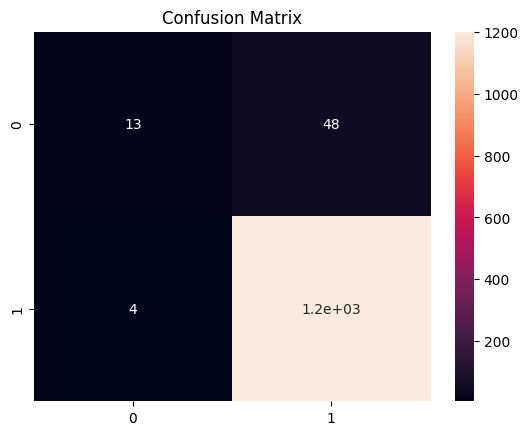

In [51]:
print(f"Test Accuracy: {100 * correct / total}%\n")

print('############ CLASSIFICATION REPORT ############')
print(classification_report(y_label,y_predicted))


confusion_matrix_df = pd.DataFrame(confusion_matrix(y_label, y_predicted))
ax = plt.axes()
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)

ax.set_title('Confusion Matrix')
plt.show()

### Discussion:

As we observe, using the standard CNN architecture with the cross-entropy loss does not fetch good results because of the large data imbalance problem. Thus, to make the model aware of the number of data samples, following below we experiment using a weighted loss strategy based on the class distributions.

## Using class weighted loss 
Here, we use a class-weighted loss strategy to counter the class imbalance problem. By the strategy, we weight the loss by a ratio based on the no. of samples present in each class. Thus, if the model wrongly predicts on the smaller class, then it gets penalized more.

In [37]:
# Load pretrained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Freeze convolutional layers to keep the pretrained weights
for param in vgg16.features.parameters():
    param.requires_grad = False

# Modify the classifier to match the number of classes in your dataset
num_classes = len(dataset.classes)
vgg16.classifier[-1] = nn.Linear(vgg16.classifier[-1].in_features, num_classes)

# Sample counts
t_samples = 24450
nt_samples = 7985

# Calculate class weights
class_weights = [t_samples / nt_samples, nt_samples / t_samples]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)  # Move to device (cuda or cpu)

# Define loss criterion and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
# specify optimizer (stochastic gradient descent) and learning rate
optimizer = optim.Adam(vgg16.parameters(), lr=1e-5)

/home/mila/s/subhrajyoti.dasgupta/.conda/envs/quick_recipe/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mila/s/subhrajyoti.dasgupta/.conda/envs/quick_recipe/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [40]:
# Train the model
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

for epoch in range(num_epochs):
    vgg16.train()
    running_loss = 0.0
    # count = 0
    for inputs, labels in train_loader:
        # if count > 2:
        #   break
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # count+=1
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

Epoch 1/5, Loss: 0.31327964350125415
Epoch 2/5, Loss: 0.24078167478326074
Epoch 3/5, Loss: 0.1747114879458132
Epoch 4/5, Loss: 0.11354769900951416
Epoch 5/5, Loss: 0.07988803027577926


### Saving the model

In [41]:
# Saving the model
PATH = '/home/mila/s/subhrajyoti.dasgupta/skin_lesion/models/'
if not os.path.exists(PATH + 'binary/'):
    os.mkdir(PATH + 'binary/')
    
torch.save(vgg16, PATH + 'multiclass/vgg16_finetuned_binary_min_oversampled_et.PTH')

### Model Evaluation

In [42]:
# Testing
correct = 0
total = 0
y_predicted = []
y_label = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vgg16(inputs)
        _, predicted = torch.max(outputs.data, 1)
        # predicted.append(torch.max(outputs.data, 1)[1])
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_predicted.extend(predicted.cpu().numpy())
        y_label.extend(labels.cpu().numpy())

Test Accuracy: 94.94869771112864%

############ CLASSIFICATION REPORT ############
              precision    recall  f1-score   support

           0       0.47      0.44      0.46        61
           1       0.97      0.98      0.97      1206

    accuracy                           0.95      1267
   macro avg       0.72      0.71      0.72      1267
weighted avg       0.95      0.95      0.95      1267



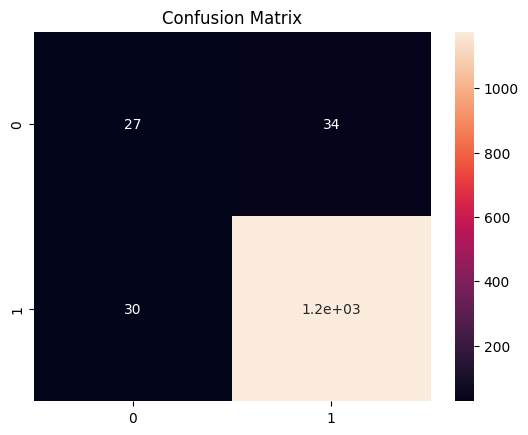

In [43]:
print(f"Test Accuracy: {100 * correct / total}%\n")

print('############ CLASSIFICATION REPORT ############')
print(classification_report(y_label,y_predicted))


confusion_matrix_df = pd.DataFrame(confusion_matrix(y_label, y_predicted))
ax = plt.axes()
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)

ax.set_title('Confusion Matrix')
plt.show()

### Discussion
As can be seen, there is an improvement in the performance of the model when we use the class-weighted strategy. The F1 score of the `NT` class improves by ~13%.

In another experiment, we also try oversampling the minority class to train the model.